# Amazon Forecast Lab

This notebook will serve as a template for the overall process of taking a non ideal time series dataset and integrating it into [Amazon Forecast](https://aws.amazon.com/forecast/).

## Overview
1. IAM setup tasks
1. Obtaining Your Data
1. Fitting the Data to Forecast
1. Building Your Predictors
1. Visualizing Predictors
1. Making Decisions
1. Next Steps

In [8]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import dateutil.parser

!pip install StringGenerator
from strgen import StringGenerator


!pip install sagemaker --upgrade
import sagemaker
from sagemaker import get_execution_role 
print("SageMaker version is: "+sagemaker.__version__)

role = get_execution_role()
print(role)



Requirement already up-to-date: sagemaker in /opt/conda/lib/python3.7/site-packages (2.16.0)
SageMaker version is: 2.16.0
arn:aws:iam::516399251338:role/service-role/AmazonSageMaker-ExecutionRole-20200918T142473


## Setup IAM 
1. Update Sagemaker execution role to include the following AWS managed policies: 
AmazonForecastFullAccess, AmazonPersonalizeFullAccess, AmazonRekognitionFullAccess

1. Create new service role "Forecast-demo-role" with the following policies attached to the role
AmazonS3FullAccess


## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. [Wikipedia](https://en.wikipedia.org/wiki/Time_series)
1. [Toward's Data Science Primer](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
1. [O'Reilly Book](https://www.amazon.com/gp/product/1492041653/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1)

For this exercise, we use the individual household electric power consumption dataset. (Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.) We aggregate the usage data hourly.

Data is already downloaded to the ../data/ directory (filename: item-demand-time.csv)

With the data downloaded, now we will import the Pandas library as well as a few other data science tools in order to inspect the information.

In [9]:
df = pd.read_csv("../data/item-demand-time.csv", dtype = object, names=['timestamp','value','item'])
df.drop(df.loc[df['item']!='client_12'].index, inplace=True)
df.head(3)

,timestamp,value,item
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


In [10]:
df.describe()

,timestamp,value,item
count,7991,7991,7991
unique,7991,2891,1
top,2014-06-21 03:00:00,45.39800995024875,client_12
freq,1,35,7991


In [13]:
print(min(df['timestamp']))
print(max(df['timestamp']))

2014-01-01 01:00:00
2014-11-29 23:00:00


Notice in the output above there are 3 columns of data:

1. The Timestamp
1. A Value
1. An Item

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present.

The dataset happens to span January 01, 2014 to November 29, 2014. For our testing we would like to keep the last month of information in a different CSV. will use Jan to Oct data for training.

In our dataset we have information about 3 clients, lets focus on client_12 on this excercise

In [14]:
jan_to_oct = df[(df['timestamp'] >= '2014-01-01') & (df['timestamp'] <= '2014-10-31')]
remaining_df = df[(df['timestamp'] >= '2014-11-01') & (df['timestamp'] <= '2014-11-29')]

Now export them to CSV files and place them into your `data` folder.

In [15]:
jan_to_oct.to_csv("../data/item-demand-time-train.csv", header=False, index=False)
remaining_df.to_csv("../data/item-demand-time-validation.csv", header=False, index=False)

### Uploading your training data to S3

At this time the data is ready to be sent to S3 where Forecast will use it later. The following cells will upload the data to S3.

Please paste the Bucket Name and the Forecast Role ARN from your Cloudformation outputs section


In [18]:
# Replace this bucket name and your Role ARN 
bucket_name = "forecast-sagemaker-demo-" + StringGenerator("[a-z0-9]{10}").render()
boto3.Session().resource('s3').create_bucket(Bucket=bucket_name,ACL='private')

role_arn = "arn:aws:iam::516399251338:role/Forecast-demo-role"
role_name = role_arn.split("/")[1]

target_time_series_filename ="elec_data/item-demand-time-train.csv"

boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file("../data/item-demand-time-train.csv")

## Getting Started With Forecast

Now that all of the required data to get started exists, our next step is to build the dataset groups and datasets required for our problem. Inside Amazon Forecast a DatasetGroup is an abstraction that contains all the datasets for a particular collection of Forecasts. There is no information sharing between DatasetGroups so if you'd like to try out various alternatives to the schemas we create below, you could create a new DatasetGroup and make your changes inside its corresponding Datasets.

The order of the process below will be as follows:

1. Create a DatasetGroup for our POC.
1. Create a `Target-Time-Series` Dataset.
1. Attach the Dataset to the DatasetGroup.
1. Import the data into the Dataset.
1. Generate Forecasts with DeepAR+.
1. Query their Forecasts.
1. Plot the Forecasts and metrics. 


The cell below defines a few global settings for our POC with the service.

In [21]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_bb_demo'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'

Now using the metada stored on this instance of a SageMaker Notebook determine the region we are operating in. If you are using a Jupyter Notebook outside of SageMaker simply define `region` as the string that indicates the region you would like to use for Forecast and S3.


In [19]:
region = boto3.session.Session().region_name
print(region)

us-east-1


Configure your AWS APIs

In [20]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [22]:
# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [29]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'forecast_bb_demo_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:516399251338:dataset-group/forecast_bb_demo_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 10, 28, 4, 34, 44, 148000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 10, 28, 4, 48, 57, 389000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '9101eec1-f4de-4d57-8d55-094015ba4d0e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 28 Oct 2020 04:54:34 GMT',
   'x-amzn-requestid': '9101eec1-f4de-4d57-8d55-094015ba4d0e',
   'content-length': '263',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [24]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [28]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

target_datasetArn = response['DatasetArn']
# Attach the Dataset to the Dataset Group:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[target_datasetArn])

ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateDataset operation: A dataset already exists with the arn: arn:aws:forecast:us-east-1:516399251338:dataset/forecast_bb_demo_ds

In [32]:
forecast.describe_dataset(DatasetArn=target_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:516399251338:dataset/forecast_bb_demo_ds',
 'DatasetName': 'forecast_bb_demo_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 10, 28, 4, 49, 40, 735000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 10, 28, 4, 49, 40, 735000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '874b5f82-0cc0-43e5-bf5b-dce5fd4f5f8e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 28 Oct 2020 04:55:45 GMT',
   'x-amzn-requestid': '874b5f82-0cc0-43e5-bf5b-dce5fd4f5f8e',
   'content-length': '499',
   'connection': 'keep-alive'},
  'RetryAttempt

In [33]:
# Finally we can call import the dataset
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=target_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [34]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:516399251338:dataset-import-job/forecast_bb_demo_ds/DSIMPORT_JOB_TARGET


The cell below will run and poll every 30 seconds until the import process has completed. From there we will be able to create a few models.

In [35]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


# Model building bits

Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future. In our case we are going to predict 3 days or 72 hours.


In [36]:
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'
deepar_predictorName= project+'_deeparp_algo_1'

forecastHorizon = 72
ForecastFrequency = "H"

NumberOfBacktestWindows = 1
BackTestWindowOffset = 72

# Forecast Horizon and Back Test Window with number of windows=1
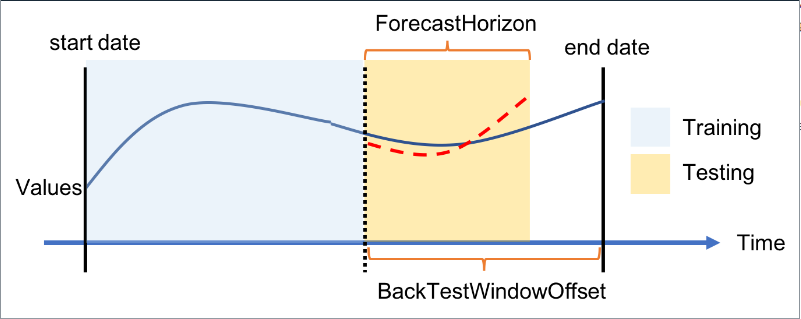

# Forecast Horizon and Back Test Window with number of windows=4
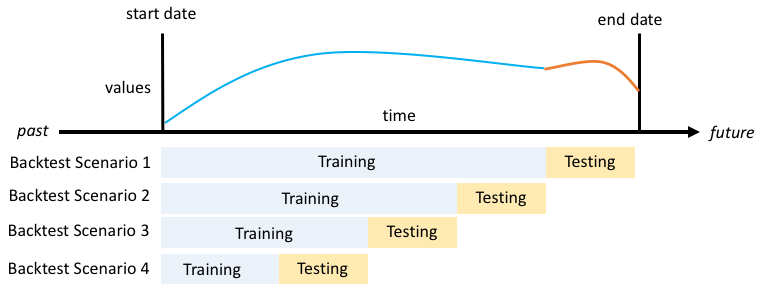

# Handling missing data
https://docs.aws.amazon.com/forecast/latest/dg/howitworks-missing-values.html
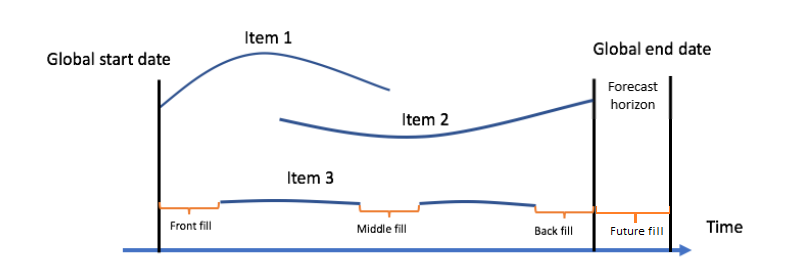

In [37]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=deepar_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )

In [38]:
# while True:
#     status = forecast.describe_predictor(PredictorArn=deeparp_create_predictor_response['PredictorArn'])['Status']
#     print(status)
#     if status != 'ACTIVE' and status != 'CREATE_FAILED':
#         sleep(60)
#     else:
#         break

CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS


KeyboardInterrupt: 

## Examine the Model

In [39]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 9.855951961568708,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.03515251548850559,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.07083997448373222,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.03551825901868135,
                                                                                          'Quantile': 0.1}]}},
                                       

### 'Metrics':     'RMSE': 9.855951961568708

## Generate a Forecast

The next phase is to generate a Forecast from the Predictor so we can see the results and understand visually 

In [40]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

In [43]:
while True:
    status = forecast.describe_forecast(ForecastArn=deeparp_forecast_arn)['Status']
    print(status)
    if status != 'ACTIVE' and status != 'CREATE_FAILED':
        sleep(30)
    else:
        break

ACTIVE


## Exporting your Forecasts to S3

In [44]:
# DeepAR + Forecast

deep_ar_path = "s3://" + bucket_name + "/DeepAR"
deep_ar_job_name = "mlimday_deep_ar_algo_forecast"
forecast.create_forecast_export_job(ForecastExportJobName=deep_ar_job_name,
                                    ForecastArn=deeparp_forecast_arn,
                                    Destination={
                                        "S3Config": {
                                            "Path": deep_ar_path,
                                            "RoleArn": role_arn
                                        }
                                    })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-1:516399251338:forecast-export-job/forecast_bb_demo_deeparp_algo_forecast/mlimday_deep_ar_algo_forecast',
 'ResponseMetadata': {'RequestId': '267aa984-3656-4537-b693-b9e9a1cd540d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 28 Oct 2020 11:41:49 GMT',
   'x-amzn-requestid': '267aa984-3656-4537-b693-b9e9a1cd540d',
   'content-length': '155',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

This exporting process is another one of those items that will take **5 minutes** to complete. Just poll for progress in the console. From the earlier page where you saw the status turn `Active` for a Forecast, click it and you can see the progress of the export.

### Obtaining the Forecasts

At this point they are all exported into S3 but you need to obtain the results locally so we can explore them, the cells below will do that.

In [49]:
# DeepAR File
s3 = boto3.resource('s3')
s3_bucket = s3.Bucket(bucket_name)
deep_ar_filename = ""
deep_ar_files = list(s3_bucket.objects.filter(Prefix="DeepAR"))

for file in deep_ar_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deep_ar_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, "../data/"+deep_ar_filename)
print(deep_ar_filename)


mlimday_deep_ar_algo_forecast_2020-10-28T11-51-53Z_part1.csv


## Evaluating the Forecast 

Note the files were downloaded and placed into the `../data/` folder for exploration.

## DeepAR+ Eval

In [50]:
actual_df = pd.read_csv("../data/item-demand-time-validation.csv", names=['timestamp','value','item'])
actual_df.tail()

,timestamp,value,item
667,2014-11-28 19:00:00,148.631841,client_12
668,2014-11-28 20:00:00,124.378109,client_12
669,2014-11-28 21:00:00,79.394693,client_12
670,2014-11-28 22:00:00,53.482587,client_12
671,2014-11-28 23:00:00,47.678275,client_12


In [51]:
actual_df = actual_df[(actual_df['timestamp'] >= '2014-11-01') & (actual_df['timestamp'] <= '2014-11-03')]

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])
for index, row in actual_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)
                                   

In [54]:
forecastResponse = forecast_query.query_forecast(
    ForecastArn=deeparp_forecast_arn,
    Filters={"item_id":"client_12"}
)

In [55]:
prediction_df_p10 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p10'])
prediction_df_p50 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p90'])

for index, row in prediction_df_p10.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

In [56]:
validation_df = results_df.pivot(columns='source', values='value', index="timestamp")

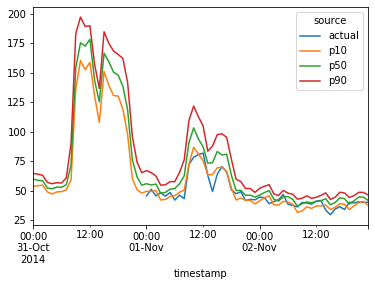

In [58]:
validation_df.plot()

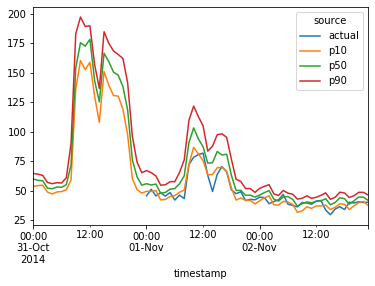

Here we can see our prediction goes from Nov 1st to November 3rd as expectged given our 72 hour interval forecast horizon. Also we can see the cyclical nature of the predictions over the entire timeframe. 

Now we are going to create a dataframe of the prediction values from this Forecast and the actual values.

First let us remove the column ID of item before continuing.

## Plotting it all together

Lastly we will take a look at our p50 prediction from  DeepAR+ where the latter leverage related time series data to see how close they are over our validation period.


In [60]:
# Creating a final df
validation_df_final = validation_df.copy()
validation_df_final = validation_df_final[['actual']]

# DeepAR+ P50:
deeparp_val_p50 = prediction_df_p50.copy()
deeparp_val_p50.rename(columns = {'p50':'DEEPARP'}, inplace = True)
# Join DFs
validation_df_final = validation_df_final.join(deeparp_val_p50, how='outer')
validation_df_final.head()


,actual,Timestamp,Value
2014-10-31 00:00:00,NaN,NaN,NaN
2014-10-31 01:00:00,NaN,NaN,NaN
2014-10-31 02:00:00,NaN,NaN,NaN
2014-10-31 03:00:00,NaN,NaN,NaN
2014-10-31 04:00:00,NaN,NaN,NaN


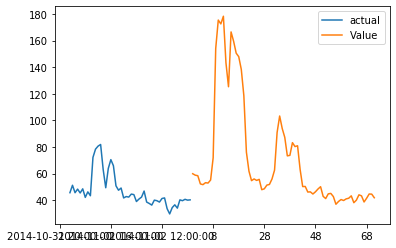

In [61]:
validation_df_final.plot()